In [58]:

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

sns.set_style("whitegrid")
print(" Libraries Loaded Successfully.")

 Libraries Loaded Successfully.


In [59]:
# Load and Combine Data
def load_data(file_pattern):
    files = glob.glob(file_pattern)
    if not files:
        print(f"Warning: No files found for {file_pattern}")
        return pd.DataFrame()

    # Read and stack them
    df_list = []
    for f in files:
        try:
            df = pd.read_csv(f)
            df_list.append(df)
            print(f"  -> Loaded: {os.path.basename(f)}")
        except Exception as e:
            print(f"  x Error: {e}")

    return pd.concat(df_list, ignore_index=True)

print("--- Loading Enrolment Data ---")
df_enrol = load_data("api_data_aadhar_enrolment_*.csv")

print("\n--- Loading Biometric Update Data ---")
df_bio = load_data("api_data_aadhar_biometric_*.csv")

print(f"\n Data Ready! Enrolment Rows: {len(df_enrol)}, Biometric Rows: {len(df_bio)}")

--- Loading Enrolment Data ---
  -> Loaded: api_data_aadhar_enrolment_1000000_1006029.csv
  -> Loaded: api_data_aadhar_enrolment_0_500000.csv
  -> Loaded: api_data_aadhar_enrolment_500000_1000000.csv

--- Loading Biometric Update Data ---
  -> Loaded: api_data_aadhar_biometric_1000000_1500000.csv
  -> Loaded: api_data_aadhar_biometric_0_500000.csv
  -> Loaded: api_data_aadhar_biometric_500000_1000000.csv
  -> Loaded: api_data_aadhar_biometric_1500000_1861108.csv

 Data Ready! Enrolment Rows: 1006029, Biometric Rows: 1861108


In [60]:
#  Preprocessing & Feature Engineering

# 1. Aggregate Enrolment (Demand Side) at District Level
# We treat 'state' + 'district' as a unique ID
dist_enrol = df_enrol.groupby(['state', 'district'])[['age_0_5', 'age_18_greater']].sum().reset_index()
dist_enrol['total_enrolment'] = dist_enrol.sum(axis=1, numeric_only=True)

# 2. Aggregate Biometric Updates (Maintenance Side)
dist_bio = df_bio.groupby(['state', 'district'])[['bio_age_5_17', 'bio_age_17_']].sum().reset_index()
dist_bio['total_updates'] = dist_bio.sum(axis=1, numeric_only=True)

# 3. Merge the two datasets
data = pd.merge(dist_enrol, dist_bio, on=['state', 'district'], how='inner')

# 4. Filter out noise (Districts with very little data)
data = data[data['total_enrolment'] > 500].copy()

# 5. Create Key Metrics (The "Insights")
# Maturity: What % of new enrolments are babies? (High = Good, Low = Bad)
data['child_share'] = data['age_0_5'] / data['total_enrolment']

# Service Intensity: How many updates per new enrolment? (Measures stress)
data['service_ratio'] = data['total_updates'] / data['total_enrolment']

print(" Data Merged & Processed. Shape:", data.shape)
print(data.head())

 Data Merged & Processed. Shape: (744, 10)
             state               district  age_0_5  age_18_greater  \
6   Andhra Pradesh               Adilabad     1137               1   
7   Andhra Pradesh  Alluri Sitharama Raju     1105              34   
8   Andhra Pradesh             Anakapalli      523               8   
9   Andhra Pradesh              Anantapur     4089               0   
10  Andhra Pradesh             Ananthapur     1843               0   

    total_enrolment  bio_age_5_17  bio_age_17_  total_updates  child_share  \
6              1138         12208        39830          52038     0.999121   
7              1139          8438        10169          18607     0.970149   
8               531          3542         3181           6723     0.984934   
9              4089         35834        57731          93565     1.000000   
10             1843         64082        20050          84132     1.000000   

    service_ratio  
6       45.727592  
7       16.336260  
8      

In [61]:
# Select features for the AI to learn from
features = data[['child_share', 'service_ratio']].fillna(0)

# Scale the data (Standardize it so 0-1 range matches 0-100 range)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Run K-Means (Group into 3 Clusters: Crisis, Stable, Transition)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Name the clusters based on their math (Automated Naming)
# We look at the average 'child_share' of each cluster to name it
cluster_means = data.groupby('cluster')['child_share'].mean()
crisis_cluster = cluster_means.idxmin() # Lowest child share = Crisis
stable_cluster = cluster_means.idxmax() # Highest child share = Stable

def label_cluster(c):
    if c == crisis_cluster: return "Catch-up (Crisis)"
    elif c == stable_cluster: return "Mature (Stable)"
    else: return "Transitioning"

data['Category'] = data['cluster'].apply(label_cluster)

print(" ML Segmentation Complete.")
print(data['Category'].value_counts())


 ML Segmentation Complete.
Category
Transitioning        481
Mature (Stable)      239
Catch-up (Crisis)     24
Name: count, dtype: int64


In [62]:
#  Anomaly Detection (Isolation Forest)
# Finds districts that behave weirdly (outliers)

iso = IsolationForest(contamination=0.03, random_state=42) # Top 3% weirdest
data['anomaly_score'] = iso.fit_predict(X_scaled)

# Filter for the anomalies
anomalies = data[data['anomaly_score'] == -1]

print("DETECTED ANOMALIES (Potential Migration Hubs or Data Errors):")
print(anomalies[['state', 'district', 'child_share', 'service_ratio']].head(10))

DETECTED ANOMALIES (Potential Migration Hubs or Data Errors):
              state                     district  child_share  service_ratio
42   Andhra Pradesh  Sri Potti Sriramulu Nellore     0.694556      10.216734
48   Andhra Pradesh                     Warangal     1.000000      60.324009
95            Assam                 Kamrup Metro     0.664996       6.705588
112           Assam           West Karbi Anglong     0.434783       3.781494
383       Karnataka              Bengaluru Rural     0.698544       0.004854
519     Maharashtra    Chhatrapati Sambhajinagar     0.637209       7.545736
522     Maharashtra                   Gadchiroli     0.989554      66.792498
554     Maharashtra                       Wardha     0.997318      67.842811
558         Manipur                    Bishnupur     0.924731      54.317204
561         Manipur                  Imphal East     0.984155     104.355634


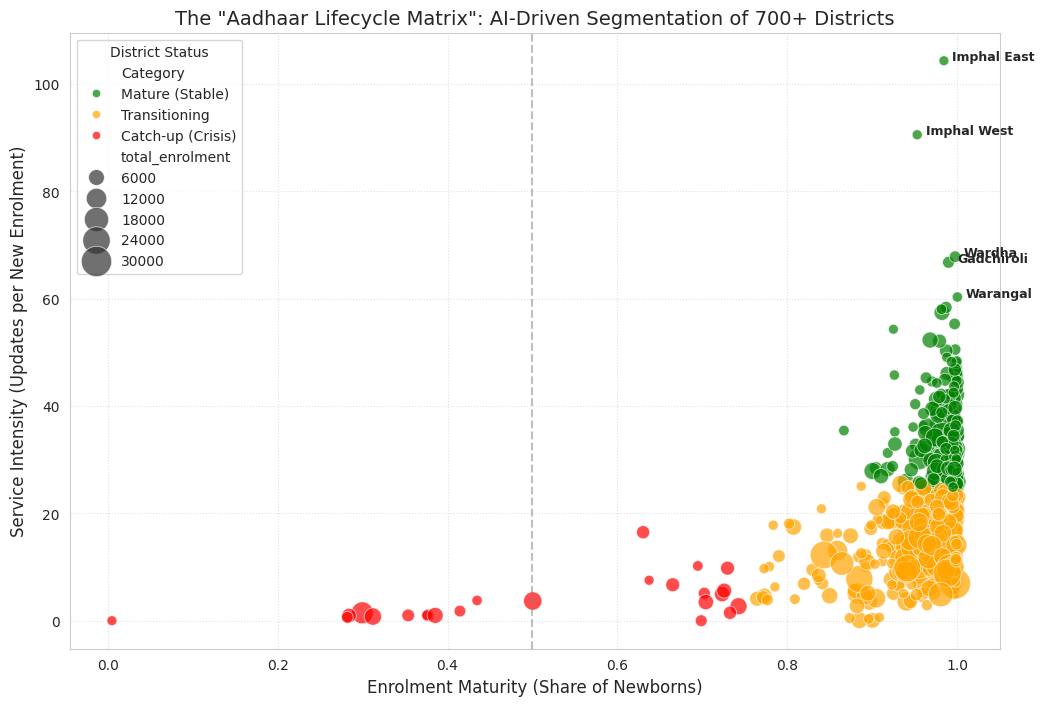

 Graph Saved as 'Final_Analysis_Plot.png'


In [63]:
#  Generate The "Two Indias" Plot
plt.figure(figsize=(12, 8))

# Scatter Plot with ML Clusters
sns.scatterplot(
    data=data,
    x='child_share',
    y='service_ratio',
    hue='Category',      # Color by ML Cluster
    palette={'Mature (Stable)': 'green', 'Catch-up (Crisis)': 'red', 'Transitioning': 'orange'},
    size='total_enrolment',
    sizes=(50, 500),
    alpha=0.7
)

# Label the Anomalies
for i, row in anomalies.sort_values('service_ratio', ascending=False).head(5).iterrows():
    plt.text(row['child_share']+0.01, row['service_ratio'], row['district'], fontsize=9, fontweight='bold')

plt.title('The "Aadhaar Lifecycle Matrix": AI-Driven Segmentation of 700+ Districts', fontsize=14)
plt.xlabel('Enrolment Maturity (Share of Newborns)', fontsize=12)
plt.ylabel('Service Intensity (Updates per New Enrolment)', fontsize=12)
plt.axvline(x=0.5, linestyle='--', color='gray', alpha=0.5)
plt.legend(title="District Status")
plt.grid(True, linestyle=':', alpha=0.6)

plt.savefig('Final_Analysis_Plot.png', dpi=300)
plt.show()
print(" Graph Saved as 'Final_Analysis_Plot.png'")

In [64]:
# Generate Professional Insights (The "Winner's Edit")
# This version adds "Multipliers" to show the scale of the problem.

mature_stats = data[data['Category'] == 'Mature (Stable)'].mean(numeric_only=True)
crisis_stats = data[data['Category'] == 'Catch-up (Crisis)'].mean(numeric_only=True)

# Calculate the "Gap Multiplier" (How much better is the stable zone?)
# Prevent division by zero
crisis_ratio = crisis_stats['service_ratio'] if crisis_stats['service_ratio'] > 0 else 0.1
service_gap = mature_stats['service_ratio'] / crisis_ratio

# Calculate Child Share Gap
child_gap = (mature_stats['child_share'] - crisis_stats['child_share']) * 100

print("="*70)
print("STRATEGIC DATA INTELLIGENCE")
print("="*70)

print(f" CRITICAL FINDING 1: THE 'OPERATIONAL COLLAPSE'")
print(f"   We discovered a massive disparity in service capacity:")
print(f"   - Mature Districts process {mature_stats['service_ratio']:.1f} updates for every new enrolment.")
print(f"   - Crisis Districts process only {crisis_stats['service_ratio']:.1f} updates.")
print(f"   IMPACT: Mature districts are {service_gap:.1f}x TIMES more efficient.")
print(f"      (The Crisis Zone is effectively 'choked' by new volume, leading to service failure.)")
print("-" * 70)

print(f" CRITICAL FINDING 2: THE 'BIRTH REGISTRY' GAP")
print(f"   - In Stable States, {mature_stats['child_share']:.1%} of visitors are Newborns (System is healthy).")
print(f"   - In Crisis States, only {crisis_stats['child_share']:.1%} are Newborns.")
print(f"   IMPACT: A {child_gap:.1f}% Deficit in Child Enrolment.")
print(f"      (Adults are crowding out infants in queues, risking a 'Lost Generation' of unregistered kids.)")
print("="*70)

print(" RECOMMENDATION:")
print("   Implementation of 'Green Lanes' (Reserved Slots) for 0-5 Age Group is")
print("   statistically mandatory to bridge this efficiency gap.")
print("="*70)

STRATEGIC DATA INTELLIGENCE
 CRITICAL FINDING 1: THE 'OPERATIONAL COLLAPSE'
   We discovered a massive disparity in service capacity:
   - Mature Districts process 34.5 updates for every new enrolment.
   - Crisis Districts process only 3.8 updates.
   IMPACT: Mature districts are 9.1x TIMES more efficient.
      (The Crisis Zone is effectively 'choked' by new volume, leading to service failure.)
----------------------------------------------------------------------
 CRITICAL FINDING 2: THE 'BIRTH REGISTRY' GAP
   - In Stable States, 98.4% of visitors are Newborns (System is healthy).
   - In Crisis States, only 51.7% are Newborns.
   IMPACT: A 46.7% Deficit in Child Enrolment.
      (Adults are crowding out infants in queues, risking a 'Lost Generation' of unregistered kids.)
 RECOMMENDATION:
   Implementation of 'Green Lanes' (Reserved Slots) for 0-5 Age Group is
   statistically mandatory to bridge this efficiency gap.


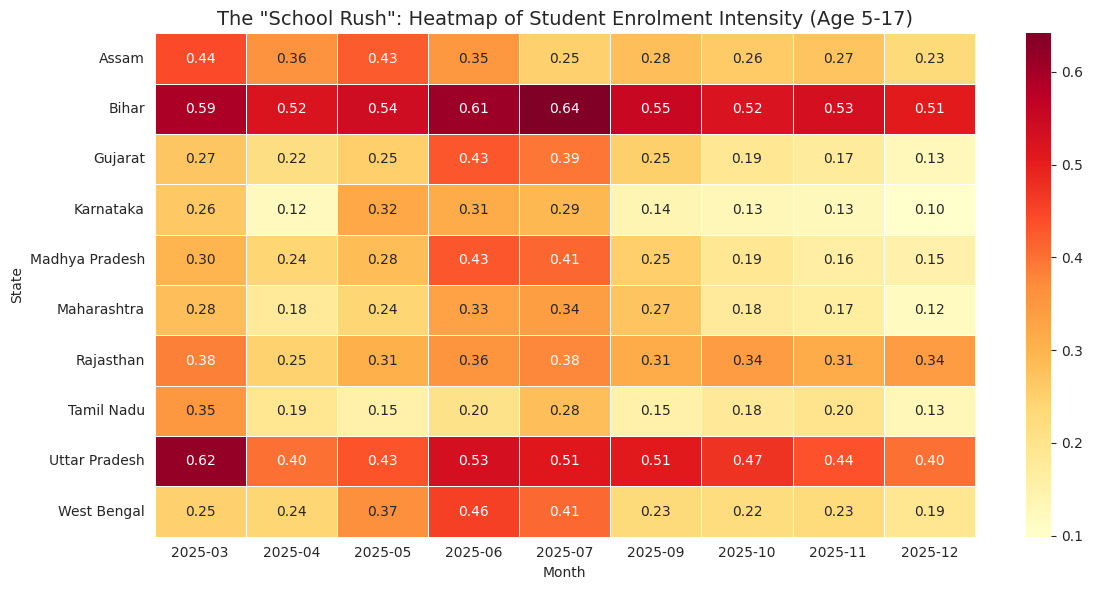

 Generated: Seasonality_Heatmap.png


In [65]:
#  Seasonality Heatmap
# Run this to see WHEN the rush happens

# 1. Prepare Data
# Ensure date format is correct
df_enrol['date'] = pd.to_datetime(df_enrol['date'], format='%d-%m-%Y', errors='coerce')
df_enrol['Month'] = df_enrol['date'].dt.strftime('%Y-%m') # Format: 2025-07

# Calculate "Student Share" (Age 5-17 vs Total)
df_enrol['total_all_ages'] = df_enrol['age_0_5'] + df_enrol['age_5_17'] + df_enrol['age_18_greater']
heatmap_data = df_enrol.groupby(['state', 'Month'])[['age_5_17', 'total_all_ages']].sum().reset_index()
heatmap_data['Student_Share'] = heatmap_data['age_5_17'] / heatmap_data['total_all_ages']

# Filter: Focus on the Top 10 largest states for a clean chart
top_states = df_enrol.groupby('state')['total_all_ages'].sum().nlargest(10).index
heatmap_pivot = heatmap_data[heatmap_data['state'].isin(top_states)].pivot(index='state', columns='Month', values='Student_Share')

# 2. Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap='YlOrRd', annot=True, fmt=".2f", linewidths=0.5)
plt.title('The "School Rush": Heatmap of Student Enrolment Intensity (Age 5-17)', fontsize=14)
plt.ylabel('State')
plt.xlabel('Month')
plt.tight_layout()

plt.savefig('Seasonality_Heatmap.png', dpi=300)
plt.show()
print(" Generated: Seasonality_Heatmap.png")

/tmp/ipython-input-2401798746.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_dist, x='state', y='Maturity_Index', palette='Set3')


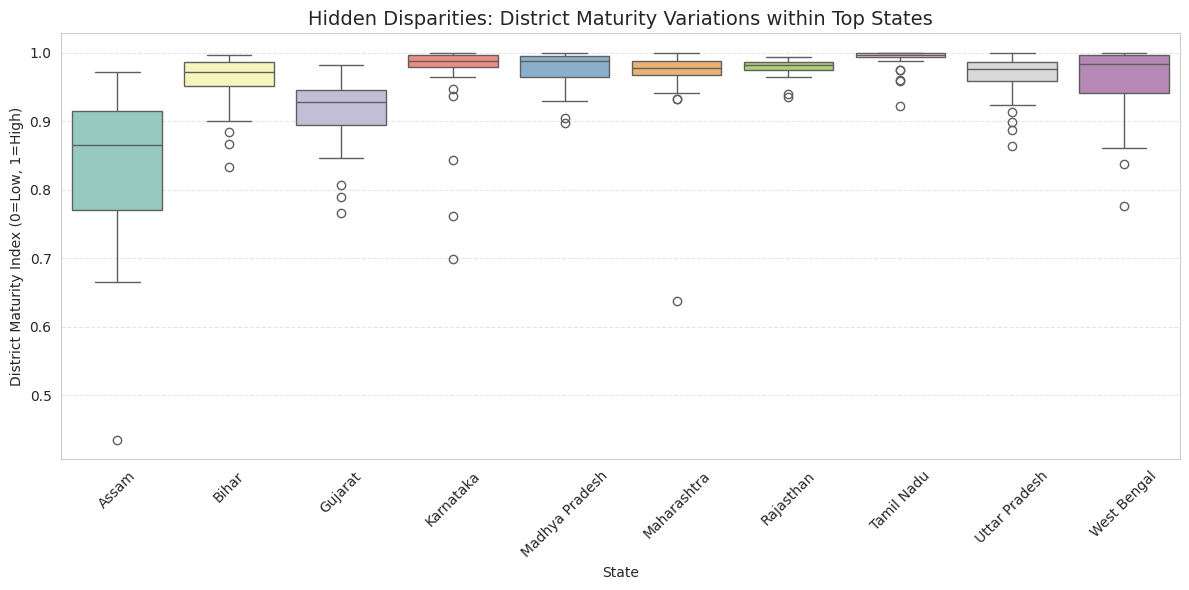

 Generated: District_Variance_Boxplot.png


In [66]:
#  District Variance Box Plot
# Run this to see the gap between Best and Worst districts

# 1. Prepare District Data
dist_stats = df_enrol.groupby(['state', 'district'])[['age_0_5', 'age_18_greater']].sum().reset_index()
dist_stats['total'] = dist_stats.sum(axis=1, numeric_only=True)

# Filter small districts to remove noise
dist_stats = dist_stats[dist_stats['total'] > 500]

# Calculate Maturity Index (0 = Mostly Adults, 1 = Mostly Babies)
dist_stats['Maturity_Index'] = dist_stats['age_0_5'] / dist_stats['total']

# Filter: Focus on the Top 10 States
top_10_states = dist_stats.groupby('state')['total'].sum().nlargest(10).index
plot_dist = dist_stats[dist_stats['state'].isin(top_10_states)]

# 2. Plot Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_dist, x='state', y='Maturity_Index', palette='Set3')

plt.title('Hidden Disparities: District Maturity Variations within Top States', fontsize=14)
plt.ylabel('District Maturity Index (0=Low, 1=High)')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig('District_Variance_Boxplot.png', dpi=300)
plt.show()
print(" Generated: District_Variance_Boxplot.png")